<a href="https://colab.research.google.com/github/scpark20/KimchiSpeech_KSS/blob/main/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 필요 라이브러리 설치

In [46]:
!pip install parallel-wavegan --quiet
!pip install g2pk --quiet
!pip install jamotools --quiet

### Parallel WaveGAN 초기화

In [27]:
from parallel_wavegan.utils import download_pretrained_model
from parallel_wavegan.utils import load_model

device='cuda'
vocoder_tag = "kss_parallel_wavegan.v1"

# NOTE: Sometimes download is failed due to "Permission denied". That is 
#   the limitation of google drive. Please retry after serveral hours.
vocoder = load_model(download_pretrained_model(vocoder_tag)).to(device).eval()
vocoder.remove_weight_norm()

from parallel_wavegan.utils import read_hdf5

stats_filename = "/root/.cache/parallel_wavegan/kss_parallel_wavegan.v1/stats.h5"
mean = read_hdf5(stats_filename, 'mean')
scale = read_hdf5(stats_filename, 'scale')
print('done')


done


### clone KimchiSpeech for KSS 

In [28]:
!git clone https://github.com/scpark20/KimchiSpeech_KSS.git
import os
import torch
os.chdir('KimchiSpeech_KSS')

Cloning into 'KimchiSpeech_KSS'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 13 (delta 2), reused 8 (delta 1), pack-reused 0
Unpacking objects: 100% (13/13), done.


### KimchiSpeech 초기화

In [40]:
from model import Model
from hparams import create_hparams
_, hp = create_hparams()
model = Model(hp)
model = model.cuda()
model.eval()

checkpoint = torch.load('kimchispeech_kss_30000.chkpnt', map_location=torch.device('cpu'))    
model.load_state_dict(checkpoint['model_state_dict'])
print('done')

done


### Text 입력

In [72]:
from g2pk import G2p
import jamotools as jt

g2p = G2p()
v = jt.Vectorizationer(rule=jt.rules.RULE_1, max_length=None)

text = "안녕하세요? 반갑습니다. 저는 에이 아이로 만들어진 음성입니다."
#text = "주어와 서술어는 호응하지 않고, 문장은 엿가락처럼 길기만 합니다. 게다가 문맥에 어울리지 않는 한자어를 남발하는 바람에 내용 파악조차 어렵습니다. 서술형 답안을 작성하고, 논술 시험을 대비하는 학생들의 글에서 흔히 발견하는 문제입니다."
#text = "동작 그만, 밑장빼기냐? 내가 빙다리 핫바지로 보이냐?"
text = "배우들의 열연과 인상 깊은 대사 덕분에 패러디와 합성소재로 쓰이기도 한다."
#text = "소년은 개울가에서 소녀를 보자 곧 윤초시네 증손녀딸이라는 걸 알 수 있었다. 소녀는 개울에다 손을 잠그고 물장난을 하고 있는 것이다. 서울서는 이런 개울물을 보지 못하기나 한 듯이."
#text = "오미크론 대유행으로 신규 확진자가 5만명 이상으로 불어난 상황에서도 정부가 사회적 거리두기 등 방역 조치를 오히려 완화하려는 듯한 메시지를 지속해서 보내고 있다."
phonemes = g2p(text)
jamos = jt.split_syllables(phonemes)
tokens = v.vectorize(phonemes)
print('phonemes :', phonemes)
print('jamos :', jamos)
print('tokens :', tokens)

phonemes : 배우드릐 여련과 인상 기픈 대사 덕뿌네 패러디와 합썽소재로 쓰이기도 한다.
jamos : ㅂㅐㅇㅜㄷㅡㄹㅢ ㅇㅕㄹㅕㄴㄱㅘ ㅇㅣㄴㅅㅏㅇ ㄱㅣㅍㅡㄴ ㄷㅐㅅㅏ ㄷㅓㄱㅃㅜㄴㅔ ㅍㅐㄹㅓㄷㅣㅇㅘ ㅎㅏㅂㅆㅓㅇㅅㅗㅈㅐㄹㅗ ㅆㅡㅇㅣㄱㅣㄷㅗ ㅎㅏㄴㄷㅏ.
tokens : [  9  22  13  34   5  39   7  40 105  13  27   7  27  45   2  30 105  13
  41  45  11  21  62 105   2  41  19  39  45 105   5  22  11  21 105   5
  25  42  10  34   4  26 105  19  22   7  25   5  41  13  30 105  20  21
  58  12  25  62  11  29  14  22   7  29 105  12  39  13  41   2  41   5
  29 105  20  21  45   5  21 106]


### Text-to-Speech

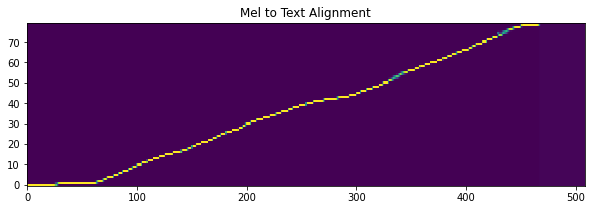

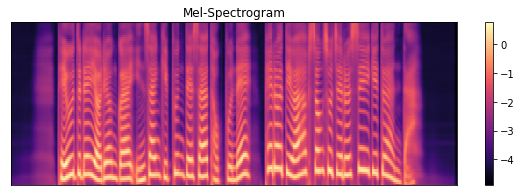

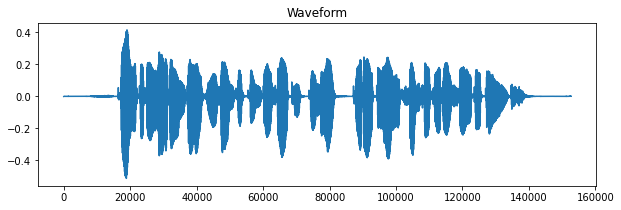

In [73]:
from IPython import display
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import time

with torch.no_grad():
    samples, alignments, _ = model.inference(torch.from_numpy(tokens).cuda().long().unsqueeze(0),
                                 temperature=1.0, clip=1.0, speed=1.0)
    
_s = samples.data.cpu().numpy()
_mels = _s[0]

_alignment = alignments[0].data.cpu().numpy()
plt.figure(figsize=[10, 3])
plt.title('Mel to Text Alignment')
plt.imshow(_alignment, aspect='auto', origin='lower', interpolation='none')
plt.show()

plt.figure(figsize=[10, 3])
plt.title('Mel-Spectrogram')
librosa.display.specshow(_mels)
plt.colorbar()
plt.show()

vocoder.eval()
with torch.no_grad():
    _mel = (_mels.T - mean) / scale
    mel = torch.from_numpy(_mel).cuda()
    wav = vocoder.inference(mel)
    _wav = wav[:, 0].data.cpu().numpy()
    
plt.figure(figsize=[10, 3])
plt.title('Waveform')
plt.plot(_wav)
plt.show()
    
import IPython.display as ipd
ipd.Audio(_wav, rate=24000)

### 한글 자모 alignment

In [74]:
def tick_to_time(tick, hop=300, sr=24000):
    time_per_tick = hop / sr
    return tick * time_per_tick

for jamo, array in zip(jamos, _alignment):
    tick = np.argmax(array)
    time = tick_to_time(tick)
    print(jamo, '%.2f' % time)

ㅂ 0.08
ㅐ 0.62
ㅇ 0.84
ㅜ 0.89
ㄷ 0.94
ㅡ 1.00
ㄹ 1.06
ㅢ 1.12
  1.16
ㅇ 1.23
ㅕ 1.29
ㄹ 1.34
ㅕ 1.39
ㄴ 1.46
ㄱ 1.53
ㅘ 1.61
  1.70
ㅇ 1.79
ㅣ 1.86
ㄴ 1.90
ㅅ 1.95
ㅏ 2.02
ㅇ 2.09
  2.12
ㄱ 2.19
ㅣ 2.24
ㅍ 2.29
ㅡ 2.38
ㄴ 2.43
  2.46
ㄷ 2.53
ㅐ 2.58
ㅅ 2.65
ㅏ 2.73
  2.79
ㄷ 2.88
ㅓ 2.94
ㄱ 3.00
ㅃ 3.06
ㅜ 3.14
ㄴ 3.21
ㅔ 3.30
  3.45
ㅍ 3.64
ㅐ 3.73
ㄹ 3.78
ㅓ 3.83
ㄷ 3.90
ㅣ 3.98
ㅇ 4.03
ㅘ 4.09
  4.12
ㅎ 4.17
ㅏ 4.21
ㅂ 4.25
ㅆ 4.33
ㅓ 4.39
ㅇ 4.45
ㅅ 4.50
ㅗ 4.56
ㅈ 4.62
ㅐ 4.70
ㄹ 4.76
ㅗ 4.81
  4.86
ㅆ 4.93
ㅡ 4.99
ㅇ 5.05
ㅣ 5.10
ㄱ 5.16
ㅣ 5.21
ㄷ 5.26
ㅗ 5.33
  5.39
ㅎ 5.43
ㅏ 5.46
ㄴ 5.51
ㄷ 5.60
ㅏ 5.71
. 5.91
